In [138]:
library(FactoMineR)
library(factoextra)
library(corrplot)
library(NbClust)
library(cluster)
library(repr)
options(repr.plot.width=4, repr.plot.height=4)
library(randomForest)
library(mlbench)
library(caret)


In [139]:
env_data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"
paired_data_file = "merged_paired_water_quality_data.txt"
tran_df <- read.delim(paste(env_data_dir, paired_data_file, sep="/"), row.names=1)
print(dim(tran_df))
table(factor(tran_df$WaterColumnPosition))

[1] 236  66



lower upper 
  175    61 

In [140]:
active_all = c("Station", "SampleDate", "WaterColumnPosition", "cruise_id", "PHEO", "TN", "TP", "CHLA", "DOP",
               "DON", "NH4F", "NO2F", "NO3F", "PC", "PO4F", "DO", "PH", "SALINITY", "WTEMP", "LinearTime", 
               "DayLength", "FallPeak", 'Discharge_Sum.15', 'Latitude')

all_df <- tran_df[,active_all]
all_df[,'Station'] = factor(all_df[,'Station'], ordered=T)
all_df[,'cruise_id'] = factor(all_df[,'cruise_id'], ordered=T)
all_df[,'WaterColumnPosition'] = factor(all_df[,'WaterColumnPosition'], ordered=T)
all_df$SampleDate <- as.POSIXlt(all_df$SampleDate)
all_df$NO3F[all_df$NO3F < 0] = NA
all_df$DOP[all_df$DOP < 0] = NA


In [141]:
library(missMDA)
nb <- estim_ncpPCA(data.matrix(all_df),ncp.min=0,ncp.max=5,method.cv="Kfold",nbsim=50)
imputed <- imputePCA(data.matrix(all_df),ncp=nb$ncp)

impute_counter = 0
for (c in colnames(all_df)) { 
    for (r in rownames(all_df)) { 
        checkval = all_df[r,c]; 
        if (is.na(checkval)){ 
            impute_counter = impute_counter + 1
            all_df[r,c] = imputed$completeObs[r,c]; 
        }
    }
}
message(paste(impute_counter, dim(all_df)[1]*dim(all_df)[2]))


  |======================================================================| 100%


43 5664


In [143]:
library(MASS)
library(nortest)
log_cols = c("PHEO", "TN", "TP", "CHLA", "DOP", "DON", "NH4F", "NO2F", "NO3F", "PC", "PO4F",
             "DO", "PH", "SALINITY", "WTEMP", 'Discharge_Sum.15')

txfms = list()
for (lc in log_cols){
    col_x = all_df[,lc]
    col_x = col_x[!is.na(col_x)] 
    neg_count = sum(col_x < 0)
    if (neg_count > 0){
        col_x = col_x + abs(min(col_x)) + 0.0001
    }
    if (sum(col_x == 0) > 0){
        col_x = col_x + 0.0001
    }

    pval_b4 = ad.test(col_x)$p.value
    pval_aft1 = ad.test(log(col_x + 1))$p.value    
    bc <- boxcox(col_x ~ 1, lambda = seq(-2, 2, 1/100), plotit=F)
    lambda <- bc$x[which.max(bc$y)]
    if (lambda == 0)
        lambda = 1
    col_x_bc = col_x^(lambda)
    pval_aft2 = ad.test(col_x_bc)$p.value
    if (pval_b4 < pval_aft2) {
        txfms[lc] = lambda
    } else {
        txfms[lc] = 1
    }
    print(paste(c(lc, neg_count, pval_b4, pval_aft1, pval_aft2, txfms[lc]), collapse=", "))
    flush.console()
}


[1] "PHEO, 0, 3.7e-24, 5.88464849136751e-10, 0.000611383063447827, -0.0800000000000001"
[1] "TN, 0, 4.13290244688002e-20, 8.21332379742281e-12, 0.0209952154600329, -0.3"
[1] "TP, 0, 1.63967035297486e-22, 3.41756519140102e-21, 0.000261540434267695, -0.11"
[1] "CHLA, 0, 3.7e-24, 0.000773268029925158, 0.0568132551309008, -0.01"
[1] "DOP, 0, 3.7e-24, 5.18107969594574e-24, 1.7570408683959e-05, -0.03"
[1] "DON, 0, 8.81508458748466e-06, 7.74310682469073e-05, 0.00319793228143199, 0.0100000000000002"
[1] "NH4F, 0, 3.7e-24, 3.7e-24, 2.21544074291052e-16, 0.16"
[1] "NO2F, 0, 3.7e-24, 3.7e-24, 1.72904456897348e-05, -0.0800000000000001"
[1] "NO3F, 11, 3.7e-24, 3.7e-24, 3.7e-24, 1"
[1] "PC, 0, 3.7e-24, 2.40403282074832e-12, 0.303969463525665, -0.28"
[1] "PO4F, 0, 3.7e-24, 3.7e-24, 1.40500452887074e-10, 0.11"
[1] "DO, 0, 1.15131579876551e-06, 9.65798855551094e-20, 1.79116051579519e-08, 1"
[1] "PH, 0, 1.43231801315283e-08, 7.93017820878712e-09, 4.73491033006902e-09, 1"
[1] "SALINITY, 0, 5.226932717047

In [144]:
external_data = c("Station", "SampleDate", "WaterColumnPosition", "cruise_id", "LinearTime","DayLength", 
                  "FallPeak", 'Discharge_Sum.15')

wc_cols = setdiff(active_all, external_data)
wc_df <- all_df[,wc_cols]
for (col_x in names(txfms)){
    if (col_x %in% colnames(wc_df))
        wc_df[,col_x] = wc_df[,col_x]^txfms[[col_x]]
}

colSums(is.na(wc_df))

PHEO       TN       TP     CHLA      DOP      DON     NH4F     NO2F 
       0        0        0        0        0        0        0        0 
    NO3F       PC     PO4F       DO       PH SALINITY    WTEMP Latitude 
       0        0        0        0        0        0        0        0

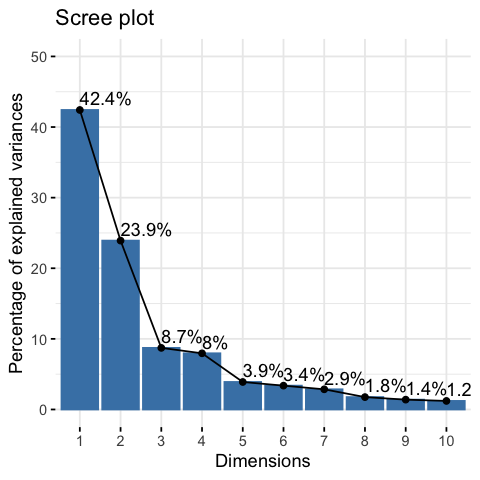

In [145]:
res.pca <- PCA(wc_df, graph = FALSE)
fviz_eig(res.pca, addlabels = TRUE, ylim = c(0, 50))

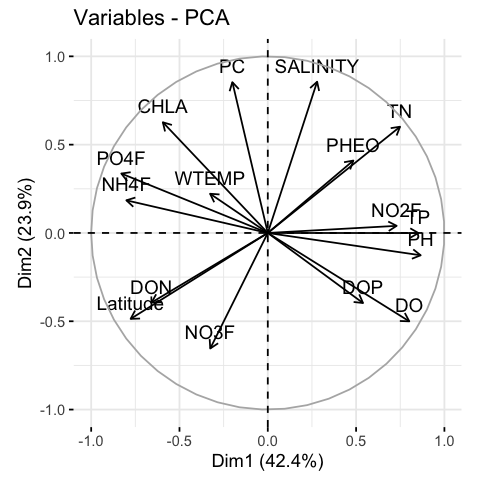

In [146]:
fviz_pca_var(res.pca, axes = c(1, 2), col.var = "black")

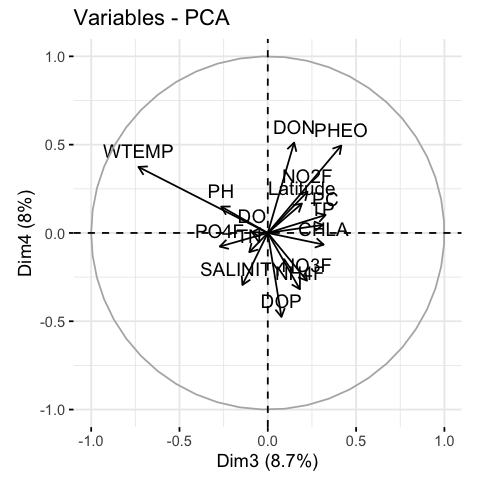

In [147]:
fviz_pca_var(res.pca, axes = c(3, 4), col.var = "black")


[1] "matrix"

[1] "matrix"

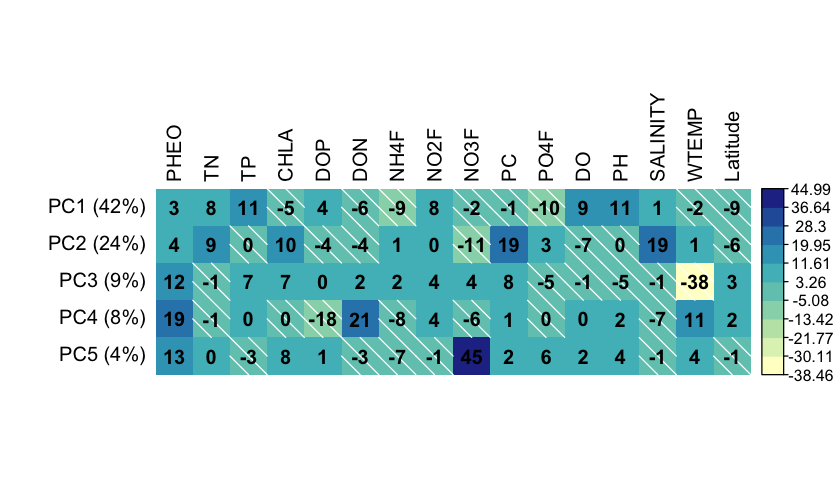

In [148]:
options(repr.plot.width=7, repr.plot.height=4)

var <- get_pca_var(res.pca)
coord_plot = t(var$coord)
coord_plot[coord_plot > 0] = 1
coord_plot[coord_plot < 0 ] = -1
contrib_plot = t(var$contrib)
class(contrib_plot)
class(coord_plot)

signed_coords = contrib_plot*coord_plot

rownames(signed_coords) <- paste("PC", 1:5, " (", round(res.pca$eig[1:5, 'percentage of variance']), "%)", sep="")

corrplot(signed_coords, method='shade', is.corr=FALSE, addCoef.col='black', tl.col = "black", number.digits=0,
         col=colorRampPalette(c("#FFFFCC","#C7E9B4","#7FCDBB","#40B6C4","#2C7FB8" ,"#253494"))(10))


*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


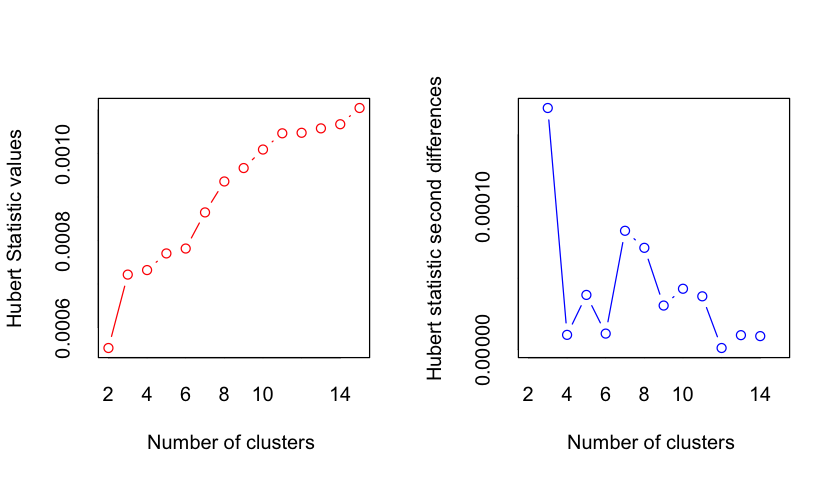

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 4 proposed 2 as the best number of clusters 
* 7 proposed 3 as the best number of clusters 
* 2 proposed 4 as the best number of clusters 
* 2 proposed 6 as the best number of clusters 
* 1 proposed 7 as the best number of clusters 
* 1 proposed 11 as the best number of clusters 
* 1 proposed 13 as the best number of clusters 
* 2 proposed 15 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  3 
 
 
**************************

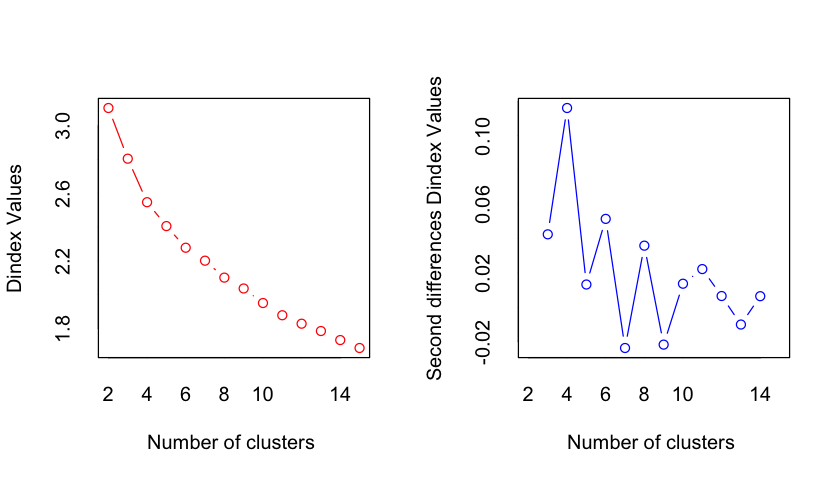

In [149]:
wc_df_sc <- scale(wc_df)
number <- NbClust(wc_df_sc, distance="euclidean", min.nc=2, max.nc=15, method='ward.D2', index='all')

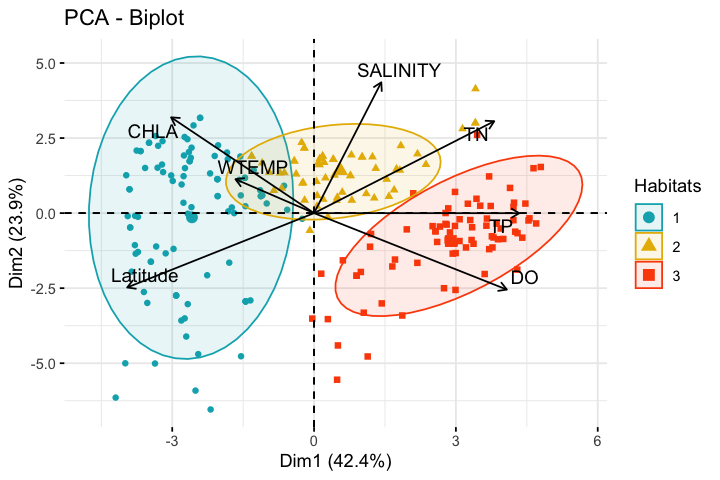

In [150]:
options(repr.plot.width=6, repr.plot.height=4)
pam.res <- pam(wc_df_sc, 3, diss=FALSE, metric='euclidean')
fviz_pca_biplot(res.pca,
                geom.ind = "point", # show points only (nbut not "text")
                col.ind = as.factor(pam.res$clustering), # color by groups
                palette = c("#00AFBB", "#E7B800", "#FC4E07"),
                addEllipses = TRUE, ellipse.type = "t",# Concentration ellipses
                legend.title = "Habitats",
                select.var = list(name = c('CHLA', 'WTEMP', 'SALINITY', 'TP', 'TN', 'DO', 'Latitude')),
                repel = TRUE, col.var = "black")

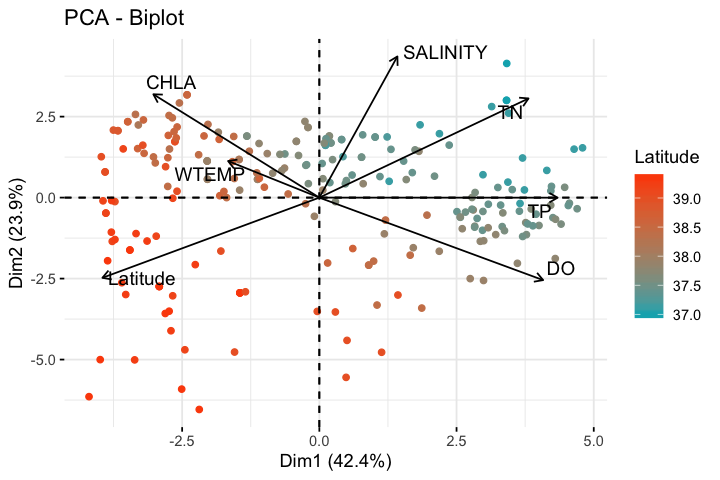

In [152]:
options(repr.plot.width=6, repr.plot.height=4)
p = fviz_pca_biplot(res.pca, label ="var", col.var = "black",
                geom.ind = "point", # show points only (nbut not "text")
                col.ind = all_df[,'Latitude'], # color by groups
                gradient.cols = c("#00AFBB", "#FC4E07"),
                legend.title = "Latitude",
                select.var = list(name = c('CHLA', 'WTEMP', 'SALINITY', 'TP', 'TN', 'DO', 'Latitude')),
                repel = TRUE)
p
#ellipsedf = cbind.data.frame(res.pca$ind$coord[,1:2], as.factor(pam.res$clustering))
#colnames(ellipsedf) <- c('X', 'Y', 'hab')
#head(ellipsedf)
#p + stat_ellipse(data=ellipsedf, aes(x=X, y=Y,group=hab),type = "euclid") 


In [165]:
# extract the classification
n_clusts = length(unique(pam.res$clustering))
habitat = as.data.frame(pam.res$clustering)
table(habitat)
colnames(habitat) <- 'HABITAT'
habitat$HABITAT <- factor(habitat$HABITAT)

# add a few more variables of interest
active_tran_plus = c(wc_cols, 'FallPeak', 'WaterColumnPosition')
tran_active_plus =  all_df[rownames(habitat), active_tran_plus]

table(tran_active_plus$WaterColumnPosition, habitat$HABITAT)

tran_active_plus$WaterColumnPosition = as.numeric(as.integer(tran_active_plus$WaterColumnPosition))

mean_cols = vector(length=n_clusts); iqr_cols = vector(length=n_clusts)
for (i in 1:n_clusts){
    mean_cols[[i]] = paste(as.character(i), "Mean", sep = "-")
    iqr_cols[[i]] = paste(as.character(i), "Std", sep = "-")
    }

clust_med = aggregate(x=tran_active_plus, by=habitat, FUN=mean)
print(mean_cols)
print(dim(clust_med))
rownames(clust_med) <- mean_cols

clust_sd = aggregate(x=tran_active_plus, by=habitat, FUN=IQR)
print(iqr_cols)
rownames(clust_sd) <- iqr_cols

clust_data = rbind(clust_med, clust_sd)

clust_data[,1] <- NULL
#for (cn in colnames(clust_data)){
#    clust_data[mean_cols,cn] = round(((clust_data[mean_cols,cn]-mean(tran_active_plus[,cn]))/sd(tran_active_plus[,cn])), 2)
#    clust_data[iqr_cols,cn] = round((clust_data[iqr_cols,cn])/sd(tran_active_plus[,cn]), 2)
#    clust_data['separation',cn] <- sum(abs(clust_data[mean_cols,cn]))
#}

#for (cn in colnames(clust_data)){
#    print(cn)
#    clust_data[mean_cols,cn] = round(((clust_data[mean_cols,cn])), 2)
#    clust_data[iqr_cols,cn] = round(clust_data[iqr_cols,cn], 2)
#    clust_data['separation',cn] <- sum(abs(clust_data[mean_cols,cn]))
#}


clust_data_t = as.data.frame(t(clust_data))
#print(sum(clust_data_t$separation))
#clust_data_t_view = clust_data_t[order(-clust_data_t$separation),]

#clust_data_t[c('DO', 'Depth_Percentage', 'SALINITY', 'WTEMP', 'NO3F', 'PC', 'CHLA', 'NH4', 'NO2F',
#               'Latitude', 'PH', 'WaterColumnPosition'),]
rownames(clust_data_t)[rownames(clust_data_t) == 'FallPeak'] = 'Seasonality'
row_select_order = c('WaterColumnPosition', "TN", 'CHLA', 'DON', 'NO3F', 'DO', 'PH', 'WTEMP', 
                     'SALINITY', 'Latitude')
tbl_to_print = round(clust_data_t[row_select_order, c(1,4,2,5,3,6)], 2)
tbl_to_print[c(1), c(1)] = round((1/99)*100, 2)
tbl_to_print[c(1), c(3)] = round((1/60)*100, 2)
tbl_to_print[c(1), c(5)] = round((59/(59 + 18))*100, 2)

tbl_to_print2 <- data.frame(lapply(tbl_to_print, as.character), stringsAsFactors=FALSE)

tbl_to_print2['Group.1'] = paste(tbl_to_print2[,c(1)], tbl_to_print2[,c(2)], sep="±")
tbl_to_print2['Group.2'] = paste(tbl_to_print2[,c(3)], tbl_to_print2[,c(4)], sep="±")
tbl_to_print2['Group.3'] = paste(tbl_to_print2[,c(5)], tbl_to_print2[,c(6)], sep="±")

#data <- within(data,  id <- paste(F, E, D, C, sep=""))
tbl_to_print3 = tbl_to_print2[,c('Group.1', 'Group.2', 'Group.3')]
rownames(tbl_to_print3) <- rownames(tbl_to_print)
write.table(tbl_to_print3, sep="\t", file=paste(env_data_dir, 'habitat_summary_table.txt', sep="/"))

habitat
 1  2  3 
99 60 77 

       
         1  2  3
  lower 98 59 18
  upper  1  1 59

[1] "1-Mean" "2-Mean" "3-Mean"
[1]  3 19
[1] "1-Std" "2-Std" "3-Std"


In [ ]:
wcpcs = res.pca$ind$coord[,c('Dim.2')]
habitat = pam.res$clustering
active_all = c('WTEMP', 'SALINITY', 'DO', 'PH', "Latitude", 'Depth_Percentage')
test_rows <- setdiff(rownames(all_df), names(habitat))
print(c(length(test_rows), length(rownames(all_df)), length(names(habitat))))
test_dataset <- all_df[test_rows, active_all]
all_in_tran = all_df[names(habitat), active_all] 

simple_dataset = cbind(all_in_tran, factor(habitat), wcpcs)
colnames(simple_dataset) <- c(active_all, 'HABITAT', 'PrinComp2')

print(str(simple_dataset))
print(str(test_dataset))

col

In [ ]:
library(xgboost)
library(caret)

set.seed(100)  # For reproducibility
# Create index for testing and training data
inTrain <- createDataPartition(y = simple_dataset$HABITAT, p = 0.75, list = FALSE)
# subset power_plant data to training
training <- simple_dataset[inTrain,]
# subset the rest to test
testing <- simple_dataset[-inTrain,]

X_train = xgb.DMatrix(as.matrix(training[,colnames(test_dataset)]))
y_train = training$HABITAT
X_test = xgb.DMatrix(as.matrix(testing[,colnames(test_dataset)]))
y_test = testing$HABITAT

xgb_trcontrol = trainControl(
  method = "cv",
  number = 5,  
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)

xgbGrid <- expand.grid(nrounds = (3:10)*10,  # this is n_estimators in the python code above
                       max_depth = 1:5,
                       colsample_bytree = 1,
                       ## The values below are default values in the sklearn-api. 
                       eta = (5:15)/100,
                       gamma=0,
                       min_child_weight = 1,
                       subsample = 1)
set.seed(0) 
xgb_model = train(
  X_train, y_train,  
  trControl = xgb_trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree"
)


xgb_pred = predict(xgb_model, newdata=X_test)
confusionMatrix(table(xgb_pred, y_test))

full_X <- xgb.DMatrix(as.matrix(simple_dataset[,colnames(test_dataset)]))
full_y <- simple_dataset$HABITAT

xgb_model_f = train(
  full_X, full_y,  
  trControl = xgb_trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree")

unknown_X <- xgb.DMatrix(as.matrix(test_dataset))

xgb_unknown_hab = predict(xgb_model_f, newdata=unknown_X)

In [ ]:
max(xgb_model_f$results$Accuracy)

In [ ]:
set.seed(2) 

y_train = training$PrinComp2
y_test = testing$PrinComp2

xgb_model2 = train(X_train, y_train, trControl = xgb_trcontrol, tuneGrid = xgbGrid,
                  method = "xgbTree")

xgb_pred2 = predict(xgb_model2, newdata=X_test)
plot(xgb_pred2, y_test)
postResample(pred = xgb_pred2, obs = y_test)
full_X <- xgb.DMatrix(as.matrix(simple_dataset[,colnames(test_dataset)]))
full_y <- simple_dataset$PrinComp2

xgb_model_f2 = train(
  full_X, full_y,  
  trControl = xgb_trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree")

xgb_model_f2$bestTune
max(xgb_model_f2$results$Rsquared)

xgb_unknown_PR2 = predict(xgb_model_f2, newdata=unknown_X)


In [ ]:
names(xgb_unknown_hab) <- rownames(test_dataset)
names(xgb_unknown_PR2) <- rownames(test_dataset)

In [ ]:
ad_out = "../otu_data/WaterQualityData/matched_cleaned_data/all_mdata_with_habitat.txt"
all_df[,'habitat'] <- NA
all_df[rownames(simple_dataset),'habitat'] <- simple_dataset[,'HABITAT']
all_df[names(xgb_unknown_hab),'habitat'] <- xgb_unknown_hab

all_df[,'AC_PrinComp2'] <- NA
all_df[rownames(simple_dataset),'AC_PrinComp2'] <- simple_dataset[,'PrinComp2']
all_df[names(xgb_unknown_PR2),'AC_PrinComp2'] <- xgb_unknown_PR2

colSums(is.na(all_df[,c('habitat', 'AC_PrinComp2')]))

write.table(x = all_df,  file = ad_out, sep = '\t')


In [ ]:
trcontrol = trainControl(
  method = "cv",
  number = 5,  
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)
tunegrid <- expand.grid(mtry=c(1:5))

fit <- train(PrinComp2~., data=simple_dataset[,c(active_all, 'PrinComp2')], method="rf", metric='Rsquared',
             tuneGrid=tunegrid, trControl=trcontrol, ntree=1500)
fit

In [ ]:
set.seed(95)
smp_size <- floor(0.75 * nrow(simple_dataset))
train_ind <- sample(seq_len(nrow(simple_dataset)), size = smp_size)
train_df <- simple_dataset[train_ind, ]
test_df <- simple_dataset[-train_ind, ]

classifier = randomForest(x = train_df[,active_all],
                          y = train_df[,'HABITAT'],
                          ntree = 1500, random_state = 0, mtry=2)

regressor_1 = randomForest(x = train_df[,active_all],
                           y = train_df[,'PrinComp1'],
                           ntree = 1500, random_state = 0, mtry=3)

regressor_2 = randomForest(x = train_df[,active_all],
                           y = train_df[,'PrinComp2'],
                           ntree = 1500, random_state = 0, mtry=2)


y_hab = predict(classifier, newdata = test_df[,active_all])
y_pc1 = predict(regressor_1, newdata = test_df[,active_all])
y_pc2 = predict(regressor_2, newdata = test_df[,active_all])

rsq <- function (x, y) cor(x, y) ^ 2

table(test_df[,'HABITAT'], y_hab)
rsq(test_df[,'PrinComp1'], y_pc1)
rsq(test_df[,'PrinComp2'], y_pc2)

In [ ]:
library(pls)
set.seed(2167)

model1 <- train(
  PrinComp1~., data = simple_dataset[,c(active_all, 'PrinComp1')], method = "pls",
  scale = TRUE,
  trControl = trainControl("cv", number = 10),
  tuneLength = 10
  )

model2 <- train(
  PrinComp2~., data = simple_dataset[,c(active_all, 'PrinComp2')], method = "pls",
  scale = TRUE,
  trControl = trainControl("cv", number = 10),
  tuneLength = 10
  )

plot(model1)
plot(model2)

summary(model1$finalModel)
summary(model2$finalModel)



In [ ]:
best.dims1=5
plsFit_1 = plsr(PrinComp1~., data=train_df[,c(active_all, 'PrinComp1')], validation="CV")
pls.pred1 = predict(plsFit_1, test_df[,c(active_all)], ncomp=5)

best.dims1=4
plsFit_2 = plsr(PrinComp2~., data=train_df[,c(active_all, 'PrinComp2')], validation="CV")
pls.pred2 = predict(plsFit_2, test_df[,c(active_all)], ncomp=4)

caret::R2(pls.pred1[1:dim(test_df)[1],1,1], test_df[,'PrinComp1'])
caret::R2(pls.pred2[1:dim(test_df)[1],1,1], test_df[,'PrinComp2'])


In [ ]:
y2_hab = predict(classifier, newdata=test_dataset)
y2_pr1 = predict(plsFit_1, newdata=test_dataset, ncomp=5)[,1,1]
y2_pr2 = predict(plsFit_2, newdata=test_dataset, ncomp=4)[,1,1]

dim(simple_dataset[,c('HABITAT', 'PrinComp1', 'PrinComp2')])
colSums(is.na(simple_dataset[,c('HABITAT', 'PrinComp1', 'PrinComp2')]))

length(y2_pr1)
length(y2_pr2)
length(y2_hab)
colSums(is.na(cbind(y2_pr1,y2_pr2,y2_hab)))



In [ ]:
select_cols = c('StationName', 'Year', 'Month', 'Discharge_Susquehanna_14', 'Latitude', 
                'habitat', 'enspie', 'faith_pd', 'day_length', 'CollectionAgency', 'anti_day_length',
                'Month_Year', 'WTEMP', 'SALINITY', 'DO', 'DOP', 'NO2F', 'PC', 'PHEO', 'NO3F', 'NH4F', 
                'TP', 'CHLA', 'TDN', 'AC_PrinComp1', 'AC_PrinComp2')


all_df$Year = factor(all_df$Year)
all_df$Month = factor(all_df$Month)
all_df$habitat = factor(all_df$habitat)

for (sc in select_cols){
    if (sc %in% colnames(all_df)){
        if (class(all_df[,sc]) != 'factor'){
            print(c(sc, shapiro.test(scale(all_df[,sc]))[['p.value']]))
        }
    } else {
        if (class(tran_df[,sc]) != 'factor'){
            print(c(sc, shapiro.test(scale(tran_df[,sc]))[['p.value']]))
        }
    }

}
